In [1]:
from typing import List, Tuple

import medical_image_segmentation.analyze_data.utils as utils
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict

import json
import os

import pydicom
import random


In [2]:
import matplotlib as mpl
mpl.rc('image', cmap='cool')

def get_discrete_colors(n: int, solid=False) -> List[Tuple[float, float, float, float]]:
    """
    Gets the discrete colors for all plots.
    
    Parameters
    ----------
    n : int The number of items to get colors for.
    solid : bool [default: False] If True, all colors are the same. Otherwise, returns a discrete sampling over a gradient.

    Returns
    -------
    List[Tuple[float, float, float, float]]
        List of tuples of RGBA colors.
    """
    if solid:
        return [mpl.colors.to_rgba("darkorchid") for x in range(n)]
    else:
        cmap = mpl.colormaps["cool"]
        return cmap(np.linspace(0, 1, n))

In [3]:
def plot_image_shapes(image_shapes: List[List[int]]):
    """
    Plot image sizes on a scatter plot, with more frequent sizes represented by larger points.

    Parameters
    ----------
    image_shapes : List[List[int]] List of width, height pairs.
    """
    shape_counter = Counter(tuple(shape) for shape in image_shapes)
    widths, heights, counts = zip(*[(shape[0], shape[1], count) for shape, count in shape_counter.items()])

    widths = np.array(widths)
    heights = np.array(heights)
    counts = np.array(counts)
    
    max_size = 10_000
    min_size = 1
    point_sizes = np.clip(counts / np.max(counts) * max_size, min_size, max_size)

    plt.figure(figsize=(10, 6))
    plt.scatter(widths, heights, s=point_sizes, c=np.sqrt(widths * heights), alpha=0.8)
    plt.colorbar(label="Sqrt of Area (pixels^2)")
    plt.title("Distribution of DICOM Image Dimensions")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.tight_layout()

    plt.show()

In [4]:
subset_image_path_list_file_path = "/scratch/gpfs/eh0560/repos/medical-image-segmentation/data/dicom_image_analysis_info/image_path_list"

In [5]:
with open(subset_image_path_list_file_path, "r") as f:
    files = f.readlines()

files = [file.strip() for file in files]

In [6]:
dimensions_output_path = "/scratch/gpfs/eh0560/repos/medical-image-segmentation/data/dicom_image_analysis_info/dicom_image_dimensions.json"

In [7]:
if os.path.isfile(dimensions_output_path):
    with open(dimensions_output_path, "r") as f:
        dimensions = json.load(f)
        subset_dimensions = {}
        for file_path in files:
            subset_dimensions[file_path] = dimensions[file_path]
        
    if len(subset_dimensions) != len(files):
        raise ValueError(f"subset_dimensions has length different than files. Length of files is {len(files)}, and length of subset_dimensions is {len(subset_dimensions)}")
else:
    subset_dimensions = utils.get_dicom_image_dimensions(files, num_processes=8)

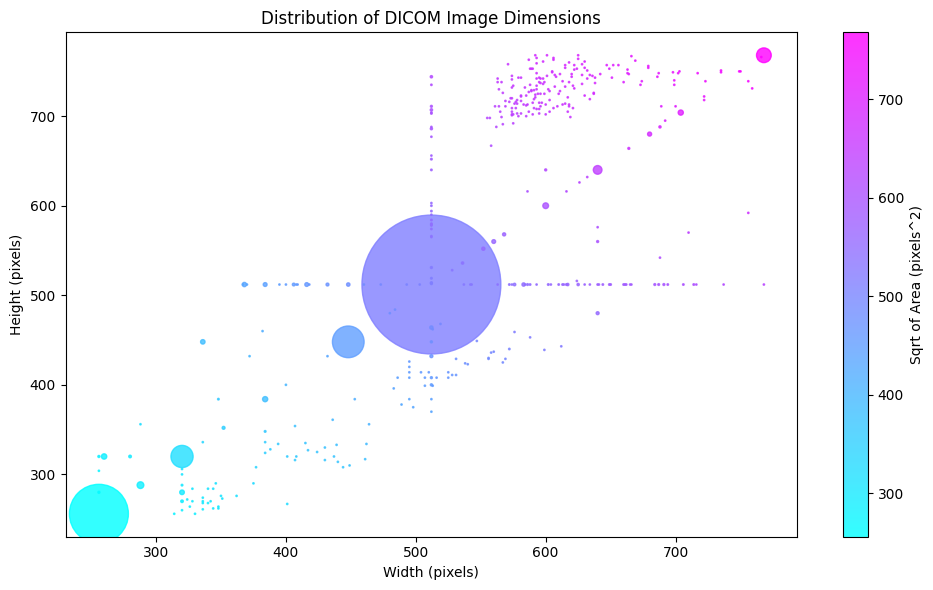

In [8]:
plot_image_shapes(list(subset_dimensions.values()))

In [9]:
dataset_counts = defaultdict(int)
for file_path in files:
    dataset_name = file_path.split("med_datasets/")[1].split("/")[0]
    dataset_counts[dataset_name] += 1

In [10]:
def plot_dataset_counts(dataset_dict: dict[str, int]):
    """
    Plot the number of images in each dataset.

    Parameters
    ----------
    dataset_dict : dict[str, int]
        A dictionary where the keys are the name of the dataset and the value is the number of images in that dataset.
    """
    names = sorted(list(dataset_dict.keys()))
    counts = []
    for dataset_name in names:
        counts.append(dataset_dict[dataset_name])
    n = len(counts)
    
    plt.figure(figsize=(10, 6))
    plt.bar(names, counts, color=get_discrete_colors(n, solid=True))
    plt.title("Distribution of DICOM Images in Each Dataset")
    plt.xlabel("Dataset")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Frequency")
    plt.tight_layout()

    plt.show()

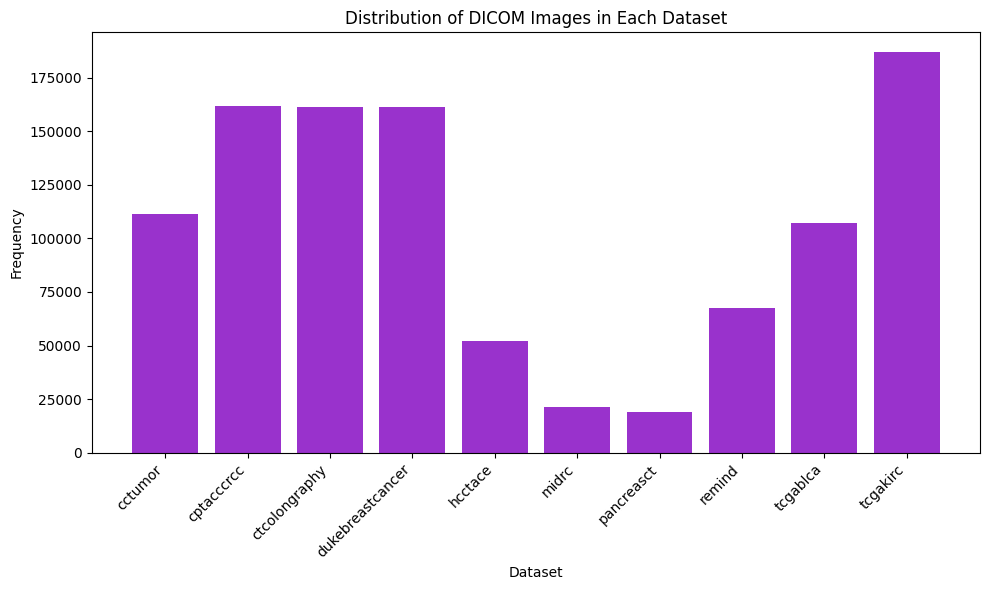

In [11]:
plot_dataset_counts(dataset_counts)

In [12]:
file_path = random.choice(files)
file_path = files[0]
ds = pydicom.dcmread(file_path)
img = ds.pixel_array
print(img.dtype)

int16


In [13]:
file_path

'/scratch/gpfs/RUSTOW/med_datasets/cctumor/manifest-1655581046477/CC-Tumor-Heterogeneity/CCTH-A01/03-03-2005-NA-PET1-82231/3.000000-CT 2.5MM STD-90746/1-001.dcm'

In [14]:
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.126923234083310066928800716710958019651
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20050303'
(0008, 0013) Instance Creation Time              TM: '132541'
(0008, 0016) SOP Class UID           

In [15]:
print(img.min(), img.max(), img.max()-img.min())

-2000 2721 4721


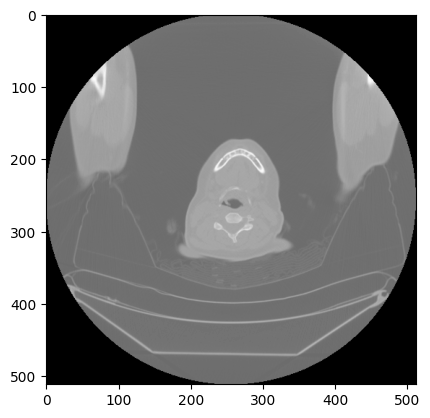

In [16]:
plt.imshow(img.astype(np.float16), cmap="gray")

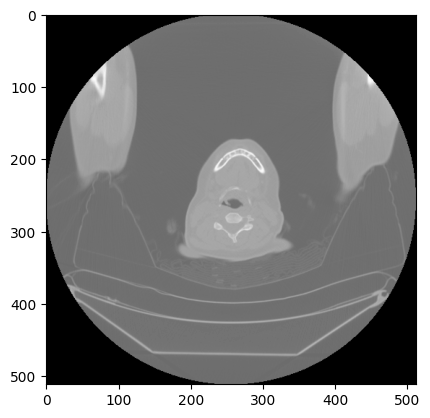

In [17]:
plt.imshow(img.astype(np.float16), cmap="gray")